In [1]:
# Libraries
import json
import pandas as pd
import csv
import numpy as np
import numpy.random as random
import re

In [2]:
# set some constants here

tagged_columns = ['admiration', ' amusement', ' anger', ' annoyance', ' approval',
       ' caring', ' confusion', ' curiosity', ' desire', ' disappointment',
       ' disapproval', ' disgust', ' embarrassment', ' excitement', ' fear',
       ' gratitude', ' grief', ' joy', ' love', ' nervousness', ' optimism',
       ' pride', ' realization', ' relief', 'remorse', ' sadness', ' surprise',
       ' neutral', ' bad_string']

# train/test/val percentage
split = [.8,.15,.05]
split_sum = sum(split)
if (not  split_sum == 1):
    # rescale to equal 1
    split = split/split_sum
print(f"train/test split: {split}")

train/test split: [0.8, 0.15, 0.05]


In [3]:
#read in CSV for  for full selected
selected_corpus = pd.read_csv('data/rejoined_selected_podcast_5000_sentences.csv')

print(f'Loaded {selected_corpus.shape[0]} sentences')

# correct string_id column name
#selected_corpus.rename(columns={"0":"StringID"})
print(selected_corpus.head())

Loaded 5000 sentences
   stringID                                             string  confidence  \
0   3967281  I don't think that we can completely We avoid ...    0.835183   
1  29184884  You don't know what you're capable of until yo...    0.901320   
2  29661525  Maybe that'll make Thompson climb up my rankin...    0.910218   
3  31833462                          Company all about vagina.    0.855159   
4  17157478                           That's what we're doing.    0.897044   

                                              source  \
0  data/raw/spotify-podcasts-2020/podcasts-transc...   
1  data/raw/spotify-podcasts-2020/podcasts-transc...   
2  data/raw/spotify-podcasts-2020/podcasts-transc...   
3  data/raw/spotify-podcasts-2020/podcasts-transc...   
4  data/raw/spotify-podcasts-2020/podcasts-transc...   

                                             context  \
0  It's not like people are like turning a blind ...   
1  This is about stepping. <b> You don't know wha...   
2  I

In [4]:
#read in CSV for string before we did string rejoining
old_selected_corpus = pd.read_csv('data/podcast_sentences_high_conf_5000_with_context.csv')

print(f'Loaded {old_selected_corpus.shape[0]} sentences')

print(old_selected_corpus.head())

Loaded 5000 sentences
   stringID                                             string  confidence  \
0   3967281  We avoid catastrophe and so I you know, if I i...    0.891355   
1  29184884  You don't know what you're capable of until yo...    0.901320   
2  29661525  Would be so courageous as to do that then what...    0.912839   
3  31833462                          Company all about vagina.    0.855159   
4  17157478                           That's what we're doing.    0.897044   

                                              source  \
0  data/raw/spotify-podcasts-2020/podcasts-transc...   
1  data/raw/spotify-podcasts-2020/podcasts-transc...   
2  data/raw/spotify-podcasts-2020/podcasts-transc...   
3  data/raw/spotify-podcasts-2020/podcasts-transc...   
4  data/raw/spotify-podcasts-2020/podcasts-transc...   

                                             context  \
0   It's not like people are like turning a blind...   
1   This is about stepping. Into the unknown to d...   
2   

In [5]:
# load first 1 tagged
tagged_1k = pd.read_csv('tag-data/latest-first-1k.csv')
print(f'Loaded {tagged_1k.shape[0]} sentences from first 1k')

# latest set of tags on the other 4 k
tagged_4k = pd.read_csv('tag-data/latest-4k.csv')
print(f'Loaded {tagged_4k.shape[0]} sentences from next 4k')

tagged = pd.concat([tagged_1k, tagged_4k])
print(tagged.shape)
print(tagged.head()) 

Loaded 1074 sentences from first 1k
Loaded 1289 sentences from next 4k
(2363, 32)
   user                                             string        id  \
0  anne  I think that that's-- She's having would they ...  31169979   
1  anne  o it was March this year and my coat was actua...  17245440   
2  anne  Yes, and I just I really appreciate the experi...  12712664   
3  anne  So they need a lot of food.-- Yeah, and then t...  13471336   
4  anne  Okay, they treated them like they were a joke....  34267843   

   admiration   amusement   anger   annoyance   approval   caring   confusion  \
0           0           0       0           0          0        0           0   
1           0           0       0           0          0        0           0   
2           0           0       0           0          0        0           0   
3           0           0       0           0          0        0           0   
4           0           0       1           0          0        0           0   

In [6]:
# Aggregate tags
aggregate_cols = np.concatenate((tagged_columns,["id"]))
df_tagged_sum = tagged.groupby('id').sum()

# find the maximum count for any one tag
df_tagged_sum['tag_agreement'] = df_tagged_sum.max(axis=1)


# keep only strings with at least one tag, and which aren't flagged as bad
good_tags = df_tagged_sum[(df_tagged_sum[" bad_string"] == 0) &
                          (df_tagged_sum["tag_agreement"] > 0)]

print(good_tags.shape)

# print out some status
print(f'Dropping {sum(df_tagged_sum[" bad_string"] >0)} strings tagged as bad')
no_tags = df_tagged_sum[df_tagged_sum["tag_agreement"] <1]
print(f'#strings with no tags:\t{ no_tags.shape[0]}')
one_tag = good_tags[good_tags["tag_agreement"] >=1 ]
print(f'#strings with some tags:\t{one_tag.shape[0]}')
two_or_more  = good_tags[good_tags["tag_agreement"] >=2 ]
print(f'#strings with agreement of at least 2:\t{sum(good_tags["tag_agreement"] >1) }')
                                               
print(f'#strings with agreement of 3:\t{sum(good_tags["tag_agreement"] >2) }')



(2006, 30)
Dropping 146 strings tagged as bad
#strings with no tags:	7
#strings with some tags:	2006
#strings with agreement of at least 2:	73
#strings with agreement of 3:	3


In [7]:
# merge back in strings
print(good_tags.shape)
good_tagged_strings = good_tags.merge(tagged[["id","string"]],
                                      left_on='id',right_on='id',
                                      how="left").drop_duplicates() 
print(good_tagged_strings.shape)
#print(good_tagged_strings.head)

(2006, 30)
(2006, 32)


In [8]:
print(good_tagged_strings.head())

# we have an issue with our tag ids getting corrupted in the tagging output just go 
# back to raw strings that were displayed for outout.
# regex for pulling the strings out of the tagging context
# throw away everything before the > save char until </b>
pattern = '(.*)>(.*)</b>'
prog = re.compile(pattern)

#Extract target string from string block
for irow, row in good_tagged_strings.iterrows(): 
    tag_context = row["string"]
    
    match = prog.match(tag_context)
    if (match != None):
        #print(match.group(2)) # group 2 matches our characters between <b> </b>
        good_tagged_strings.at[irow,"target_string"]= match.group(2)
    else:
        print(f'did not find substring for {tag_context}') # get the strings from the saved chars

print(good_tagged_strings.head())

      id  admiration   amusement   anger   annoyance   approval   caring  \
0   4847           0           0       0           0          0        0   
1  32364           0           0       1           0          0        0   
2  44522           0           0       0           0          0        0   
4  53582           0           0       0           0          0        0   
5  59047           0           0       0           0          0        0   

    confusion   curiosity   desire  ...   pride   realization   relief  \
0           0           0        0  ...       0             0        0   
1           0           0        0  ...       0             0        0   
2           1           1        0  ...       0             0        0   
4           0           0        0  ...       0             0        0   
5           0           1        0  ...       0             0        0   

   remorse   sadness   surprise   neutral   bad_string  tag_agreement  \
0        0         0     

In [9]:
# convert the indicator flags into best tag selection

# in case of a tie, this will return the earliest in tag order - Sub optimal
good_tagged_strings["top_tag"] = good_tagged_strings[tagged_columns].idxmax(axis=1)
print(good_tagged_strings)

            id  admiration   amusement   anger   annoyance   approval  \
0         4847           0           0       0           0          0   
1        32364           0           0       1           0          0   
2        44522           0           0       0           0          0   
4        53582           0           0       0           0          0   
5        59047           0           0       0           0          0   
...        ...         ...         ...     ...         ...        ...   
2188  34290070           0           0       0           0          0   
2189  34298061           0           0       0           0          0   
2190  34309661           0           0       0           0          1   
2191  34310858           0           0       0           0          0   
2192  34317582           0           0       0           0          1   

       caring   confusion   curiosity   desire  ...   relief  remorse  \
0           0           0           0        0  ..

In [10]:
# split into train/test/val

# based of the 266 utils split, but with validation also
def get_train_test_sents(df, p=[.8,.1,.1]):
    """Generate train/test split for unsupervised tasks.

    Args:
      corpus: nltk.corpus that supports sents() function
      split (double): fraction to use as training set
      shuffle (int or bool): seed for shuffle of input data, or False to just
      take the training data as the first xx% contiguously.

    Returns:
      train_sentences, test_sentences ( list(list(string)) ): the train and test
      splits
    """

    index_values = random.choice([0,1,2], size=df.shape[0], replace=True, p=p)
    print(f"Loaded {index_values.shape} sentences ")

    
    train_sentences = df.iloc[index_values == 0]
    
    test_sentences = df.iloc[index_values == 1]
    
    val_sentences = df.iloc[index_values == 2]

    print(f"Training set: {train_sentences.shape[0]} sentences")
    print(f"Test set: {test_sentences.shape[0]} sentences")
    print(f"Validation set: {val_sentences.shape[0]} sentences")
    
    return train_sentences, test_sentences, val_sentences

train_df, test_df, val_df = get_train_test_sents(good_tagged_strings,p=split)
print(train_df.shape, test_df.shape, val_df.shape)

Loaded (2006,) sentences 
Training set: 1628 sentences
Test set: 285 sentences
Validation set: 93 sentences
(1628, 34) (285, 34) (93, 34)


In [11]:
# write out data files
train_df.to_csv('data/training.csv', sep=',',index=False)
test_df.to_csv('data/test.csv', sep=',',index=False)
val_df.to_csv('data/val.csv', sep=',',index=False)

In [3]:
train_df = pd.read_csv('data/training.csv', sep=',')
test_df = pd.read_csv('data/test.csv', sep=',')
val_df = pd.read_csv('data/val.csv', sep=',')



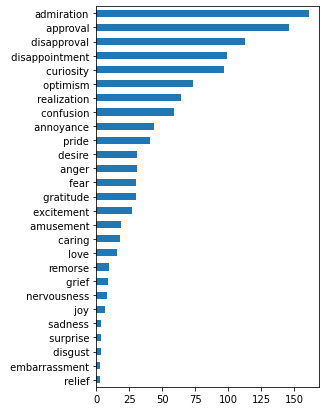

In [4]:
train_df['top_tag'].value_counts().tail(-1).plot(kind='barh',figsize=(4,7)).invert_yaxis()

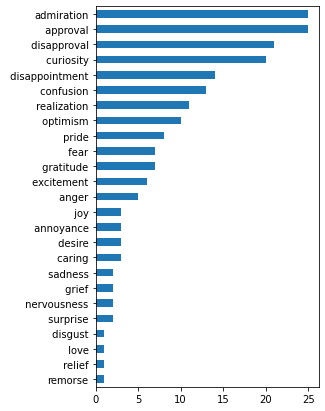

In [5]:
test_df['top_tag'].value_counts().tail(-1).plot(kind='barh',figsize=(4,7)).invert_yaxis()

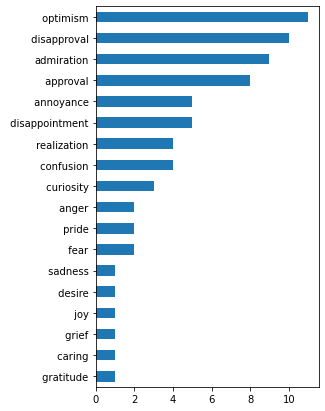

In [6]:

val_df['top_tag'].value_counts().tail(-1).plot(kind='barh',figsize=(4,7)).invert_yaxis()

In [9]:
def count_tie_tags(data):
    data["total_tags"] = data[tagged_columns].sum(axis=1)
    print(data[data["total_tags"] != data["tag_agreement"]])
    
count_tie_tags(train_df)

            id  admiration   amusement   anger   annoyance   approval  \
2        44522           0           0       0           0          0   
14      170313           1           0       0           0          1   
18      225608           1           0       0           0          0   
23      268163           0           0       0           0          0   
28      298445           1           0       0           0          1   
...        ...         ...         ...     ...         ...        ...   
1613  34137337           0           0       0           0          0   
1615  34171624           0           0       0           0          0   
1621  34259924           0           0       0           0          0   
1622  34267843           0           0       1           0          0   
1627  34317582           0           0       0           0          1   

       caring   confusion   curiosity   desire  ...  remorse   sadness  \
2           0           1           1        0  .